# utils & framework

In [1]:
from collections.abc import Iterable
from IPython.core.display import Markdown
from sympy import *
from sympy.vector import CoordSys3D, Vector
from scipy import constants

tag_id = 0
conditions = {}
values = {}
formulas_names = {}


def reset():
    global tag_id, conditions, values, formulas_names
    tag_id = cond_id_bk
    conditions = conditions_bk.copy()
    values = values_bk.copy()
    formulas_names = formulas_names_bk.copy()


cond_id_bk = tag_id
conditions_bk = conditions
values_bk = values
formulas_names_bk = formulas_names


def set_restore_point():
    global cond_id_bk, conditions_bk, values_bk, formulas_names_bk
    cond_id_bk = tag_id
    conditions_bk = conditions.copy()
    values_bk = values.copy()
    formulas_names_bk = formulas_names.copy()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression):
    while True:
        left = False
        for (key, value) in values.items():
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$",f:bool=False):
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(expression, message, tag="answer")


def beautiful_peek(symbol, message="$", tag=None):
    value = substitute_values(symbol)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression=None, message="$", tag = None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    save_as_variable(symbol, expression)
    return symbol


def beautiful_formula(symbol: str, expression, message="$", ):
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))



## Common

In [2]:
coord = CoordSys3D('')
epsilon = symbols('epsilon_0')
k = 1 / (4 * pi * epsilon)
q = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * q * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon), "by Gauss's law:$")
P = beautiful_formula('\\varphi', k * q / pos.magnitude(), 'electric potential:$')
set_restore_point()

by Coulomb's law:$$E=\left(\frac{\mathbf{{x}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}\tag{0}$$

by Gauss's law:$$\phi_{e} = \frac{Q_{sum}}{\epsilon_{0}}\tag{1}$$

electric potential:$$\varphi=\frac{q}{4 \pi \epsilon_{0} \sqrt{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}}}\tag{2}$$

## 12.7

In [3]:
def f127():
    reset()
    p = symbols('p')
    l = symbols('l')
    beautiful_compute(q * l, p, "by define of $p$:$")

    dx = symbols('dx')
    E_appro = beautiful_at(E, {x: x + dx, }, "because:$")
    E_appro = beautiful_formula("E_{approx}", series_vector(E_appro, dx).simplify(),
                                "so for tiny dx ,let us series it to 2nd:$")
    # E_appro = beautiful_formula('E_{approx}',)
    E_1 = beautiful_at(E_appro, {dx: - l / 2, z: 0}, "$E_1$:$")
    E_2 = beautiful_at(E_appro, {dx: l / 2, z: 0, q: -1 * q}, "$E_2$:$")
    E_total = simplify(E_1 + E_2)
    beautiful_print(substitute_values(E_total), "$E_{total}$ :$", tag="answer")


f127()

by define of $p$:$$l q = p$$

because:$$E\bigg|_{\mathbf{{x}_{}}=\mathbf{{x}_{}} + dx}=\left(\frac{q \left(\mathbf{{x}_{}} + dx\right)}{4 \pi \epsilon_{0} \left(\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2} + \left(\mathbf{{x}_{}} + dx\right)^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2} + \left(\mathbf{{x}_{}} + dx\right)^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2} + \left(\mathbf{{x}_{}} + dx\right)^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}$$

so for tiny dx ,let us series it to 2nd:$$E_{approx}=\left(\frac{q \left(\mathbf{{x}_{}} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right) - dx \left(2 \mathbf{{x}_{}}^{2} - \mathbf{{y}_{}}^{2} - \mathbf{{z}_{}}^{2}\right)\right)}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q \left(\mathbf{{x}_{}}^{2} - 3 \mathbf{{x}_{}} dx + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q \left(\mathbf{{x}_{}}^{2} - 3 \mathbf{{x}_{}} dx + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{k}_{}}\tag{3}$$

$E_1$:$$E_{approx}\bigg|_{dx=- \frac{l}{2}\,\mathbf{{z}_{}}=0}=\left(\frac{q \left(2 \mathbf{{x}_{}} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right) + l \left(2 \mathbf{{x}_{}}^{2} - \mathbf{{y}_{}}^{2}\right)\right)}{8 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q \left(2 \mathbf{{x}_{}}^{2} + 3 \mathbf{{x}_{}} l + 2 \mathbf{{y}_{}}^{2}\right)}{8 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{j}_{}}$$

$E_2$:$$E_{approx}\bigg|_{dx=\frac{l}{2}\,\mathbf{{z}_{}}=0\,q=- q}=\left(- \frac{q \left(2 \mathbf{{x}_{}} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right) - l \left(2 \mathbf{{x}_{}}^{2} - \mathbf{{y}_{}}^{2}\right)\right)}{8 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{i}_{}} + \left(- \frac{\mathbf{{y}_{}} q \left(2 \mathbf{{x}_{}}^{2} - 3 \mathbf{{x}_{}} l + 2 \mathbf{{y}_{}}^{2}\right)}{8 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{j}_{}}$$

$E_{total}$ :$$\left(\frac{p \left(2 \mathbf{{x}_{}}^{2} - \mathbf{{y}_{}}^{2}\right)}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{3 \mathbf{{x}_{}} \mathbf{{y}_{}} p}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2}\right)^{\frac{5}{2}}}\right)\mathbf{\hat{j}_{}}\tag{answer}$$

### 12.10

In [4]:
def f1210():
    reset()
    lmd = symbols('lambda_0')
    angle = Symbol('theta')
    R = symbols('R', positive=True)
    with D(angle, 'd\\theta') as d_theta:
        q_dense = beautiful_compute('lambda', lmd * sin(angle), "given :$")
        dq = beautiful_compute('dq', q_dense * R * d_theta, "so:$")

        dE = beautiful_at(E, {x: -R * cos(angle), y: -R * sin(angle), z: 0, q: dq}, "compute $dE$ : $")
        dE = substitute_values(dE)
        beautiful_print(dE, "inlined:$")

        result = integrate_vector(dE, (angle, 0, 2 * pi))

    beautiful_answer(result, "integrated:$")


f1210()

given :$$\lambda = \lambda_{0} \sin{\left(\theta \right)}$$

so:$$dq = R d\theta \lambda$$

compute $dE$ : $$E\bigg|_{\mathbf{{x}_{}}=- R \cos{\left(\theta \right)}\,\mathbf{{y}_{}}=- R \sin{\left(\theta \right)}\,\mathbf{{z}_{}}=0\,q=dq}=\left(- \frac{dq \cos{\left(\theta \right)}}{4 \pi R^{2} \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(- \frac{dq \sin{\left(\theta \right)}}{4 \pi R^{2} \epsilon_{0}}\right)\mathbf{\hat{j}_{}}$$

inlined:$$\left(- \frac{d\theta \lambda_{0} \sin{\left(2 \theta \right)}}{8 \pi R \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(- \frac{d\theta \lambda_{0} \sin^{2}{\left(\theta \right)}}{4 \pi R \epsilon_{0}}\right)\mathbf{\hat{j}_{}}$$

integrated:$$\left(- \frac{\lambda_{0}}{4 R \epsilon_{0}}\right)\mathbf{\hat{j}_{}}\tag{answer}$$

### 12.12

In [5]:
def f1212():
    reset()
    theta = Symbol('theta')
    a = Symbol('a', positive=True)
    p1x = a * cos(theta)
    p1y = a * sin(theta)
    rho = Symbol('rho')
    beautiful_print(rho, "define the electric density by line is:$")
    with D(theta, 'd\\theta') as d_theta:
        dq1 = beautiful_compute('dq1', d_theta * a * rho)
        dE1 = beautiful_at(E, {x: p1x, y: p1y, z: 0, q: dq1}, "compute $dE_1$ :$")
        dE1 = substitute_values(dE1)
        beautiful_print(dE1, "inlined:$")
        E1 = integrate_vector(dE1, (theta, pi / 2, pi * 3 / 2))
    E1= substitute_values(E1)
    beautiful_print(E1, "integrated to $E_1$: $")

    p2x = Symbol('x')
    p2y = Symbol('y')
    with D(p2x) as dx:
        dq2 = beautiful_compute('dq2', dx * rho)
        dEt = beautiful_at(E, {x: p2x, y: p2y, z: 0, q: dq2}, "compute $dE_{line}$ : $")
        dEt = substitute_values(dEt)
        beautiful_print(dEt, "inlined:$")
        Et = integrate_vector(dEt, (p2x, 0, oo))
    Et = substitute_values(Et)
    E2 = Et.subs(p2y, a)
    beautiful_print(E2, "integrated to $E_2$: $")
    E3 = spf(Et.subs(p2y, -a))
    beautiful_print(E3, "integrated to $E_3$: $")

    ans = beautiful_compute('E_{total}', E1 + E2 + E3, "sub them up:$")
    beautiful_answer(ans, "result:$")


f1212()

define the electric density by line is:$$\rho$$

$$dq_{1} = a d\theta \rho$$

compute $dE_1$ :$$E\bigg|_{\mathbf{{x}_{}}=a \cos{\left(\theta \right)}\,\mathbf{{y}_{}}=a \sin{\left(\theta \right)}\,\mathbf{{z}_{}}=0\,q=dq_{1}}=\left(\frac{dq_{1} \cos{\left(\theta \right)}}{4 \pi a^{2} \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(\frac{dq_{1} \sin{\left(\theta \right)}}{4 \pi a^{2} \epsilon_{0}}\right)\mathbf{\hat{j}_{}}$$

inlined:$$\left(\frac{d\theta \rho \cos{\left(\theta \right)}}{4 \pi a \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(\frac{d\theta \rho \sin{\left(\theta \right)}}{4 \pi a \epsilon_{0}}\right)\mathbf{\hat{j}_{}}$$

integrated to $E_1$: $$\left(- \frac{\rho}{2 \pi a \epsilon_{0}}\right)\mathbf{\hat{i}_{}}$$

$$dq_{2} = dx \rho$$

compute $dE_{line}$ : $$E\bigg|_{\mathbf{{x}_{}}=x\,\mathbf{{y}_{}}=y\,\mathbf{{z}_{}}=0\,q=dq_{2}}=\left(\frac{dq_{2} x}{4 \pi \epsilon_{0} \left(x^{2} + y^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{dq_{2} y}{4 \pi \epsilon_{0} \left(x^{2} + y^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}}$$

inlined:$$\left(\frac{dx \rho x}{4 \pi \epsilon_{0} \left(x^{2} + y^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{dx \rho y}{4 \pi \epsilon_{0} \left(x^{2} + y^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}}$$

integrated to $E_2$: $$\left(\frac{\rho}{4 \pi a \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\rho}{4 \pi a \epsilon_{0}}\right)\mathbf{\hat{j}_{}}$$

integrated to $E_3$: $$\left(\frac{\rho}{4 \pi a \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(- \frac{\rho}{4 \pi a \epsilon_{0}}\right)\mathbf{\hat{j}_{}}$$

sub them up:$$E_{total} = \mathbf{\hat{0}}$$

result:$$\mathbf{\hat{0}}\tag{answer}$$

### 12.17
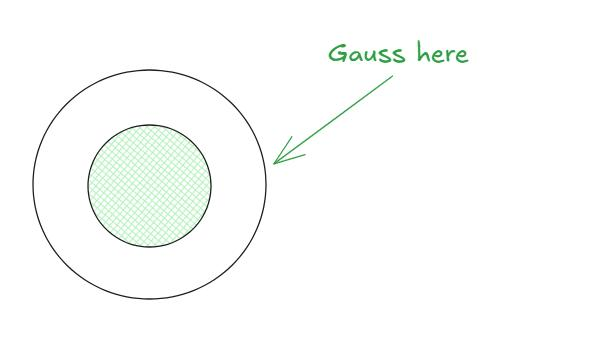

take a piece of it by length:$$l$$

so:$$Q_{full} = 2 \pi a l \sigma$$

so:$$Q{\left(r \right)} = \begin{cases} 0 & \text{for}\: a > r \\Q_{full} & \text{otherwise} \end{cases}$$

make the Gauss surface be a cylinder, and easily the flux of E is:$$\phi{\left(r \right)} = 2 \pi l r E_{r}{\left(r \right)}\tag{3}$$

$\left ( 1 \right ) ,\left ( 3 \right )  \Longrightarrow$

$$E_{r}{\left(r \right)} = \frac{Q{\left(r \right)}}{2 \pi \epsilon_{0} l r}$$

$$\phi{\left(r \right)} = \frac{Q{\left(r \right)}}{\epsilon_{0}}$$

inlined:$$E_{r}{\left(r \right)} = \begin{cases} 0 & \text{for}\: a > r \\\frac{a \sigma}{\epsilon_{0} r} & \text{otherwise} \end{cases}\tag{answer}$$

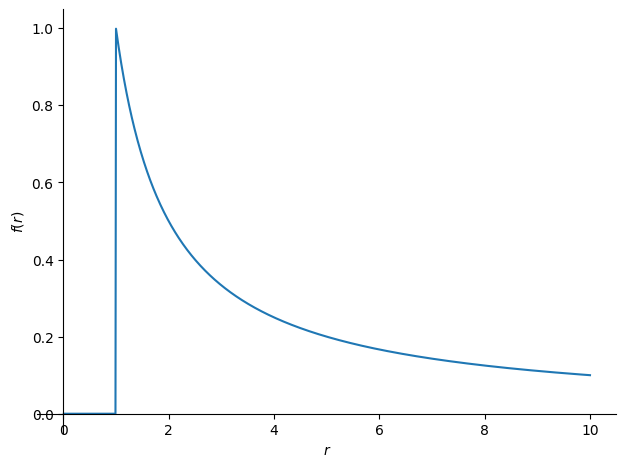

In [6]:
def f1217():
    reset()
    r = Symbol('r', positive=True)
    dense = Symbol('sigma')
    radius = Symbol('a')
    length = Symbol('l')
    beautiful_print(length, "take a piece of it by length:$")
    Q_full = beautiful_compute('Q_{full}', 2 * pi * radius * length * dense, 'so:$')

    Q = beautiful_compute(Function('Q')(r), Piecewise((0, r < radius), (Q_full, r >= radius)), 'so:$')
    E_r = Function('E_r')(r)
    flux = Function('phi')(r)
    flu = beautiful_condition(Eq(flux, length * E_r * 2 * pi * r),
                              'make the Gauss surface be a cylinder, and easily the flux of E is:$')
    beautiful_solve([Gauss_law, flu], [flux, E_r], {electric_flux: flux, enclosed_charge_sum: Q})

    beautiful_peek(E_r, "inlined:$","answer")
    save_as_variable(dense, 1)
    save_as_variable(radius, 1)
    save_as_variable(length, 1)
    save_as_variable(epsilon, 1)
    plot(substitute_values(E_r), (r, 0, 10))


f1217()

### 12.18

In [7]:
def f1218():
    reset()
    dense = Symbol('sigma')
    dense1 = Symbol('lambda')
    dense2 = -1 * dense1
    r = Symbol('r', positive=True)
    R = Symbol('R', positive=True)
    R1 = Symbol('R_1', positive=True)
    R2 = Symbol('R_2', positive=True)

    E = beautiful_formula('E(r)',Piecewise((0,r< R),(k* R * dense / (r),r>=R)), "reuse the result form 1217:$")
    E1 = beautiful_at(E, {dense: dense1, R: R1}, 'for $E_1$:$')
    E2 = beautiful_at(E, {dense: dense2, R: R2}, 'for $E_2$:$')

    beautiful_compute('E_{total}', E1 + E2, "so:$")


f1218()

reuse the result form 1217:$$E(r)=\begin{cases} 0 & \text{for}\: R > r \\\frac{R \sigma}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}\tag{3}$$

for $E_1$:$$E(r)\bigg|_{\sigma=\lambda\,R=R_{1}}=\begin{cases} 0 & \text{for}\: R_{1} > r \\\frac{R_{1} \lambda}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}$$

for $E_2$:$$E(r)\bigg|_{\sigma=- \lambda\,R=R_{2}}=\begin{cases} 0 & \text{for}\: R_{2} > r \\- \frac{R_{2} \lambda}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}$$

so:$$E_{total} = \begin{cases} 0 & \text{for}\: R_{1} > r \\\frac{R_{1} \lambda}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases} + \begin{cases} 0 & \text{for}\: R_{2} > r \\- \frac{R_{2} \lambda}{4 \pi \epsilon_{0} r} & \text{otherwise} \end{cases}$$

### 1220
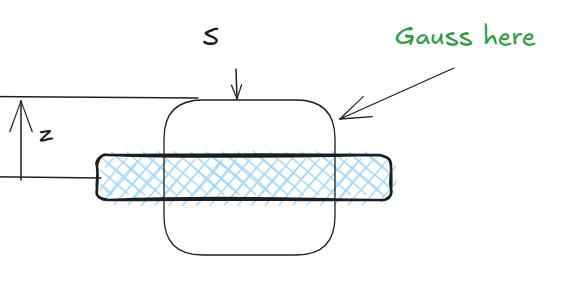

choose the size of the surface:$$S$$

distribution of q:$$Q{\left(z \right)} = \begin{cases} 2 S \rho z & \text{for}\: z < \frac{D}{2} \\D S \rho & \text{otherwise} \end{cases}$$

easily the flux of E is:$$\phi{\left(z \right)} = 2 S E{\left(z \right)}\tag{3}$$

$\left ( 3 \right ) ,\left ( 1 \right )  \Longrightarrow$

$$E{\left(z \right)} = \frac{Q{\left(z \right)}}{2 S \epsilon_{0}}$$

$$\phi{\left(z \right)} = \frac{Q{\left(z \right)}}{\epsilon_{0}}$$

inlined:$$E{\left(z \right)} = \begin{cases} \frac{\rho z}{\epsilon_{0}} & \text{for}\: D > 2 z \\\frac{D \rho}{2 \epsilon_{0}} & \text{otherwise} \end{cases}\tag{answer}$$

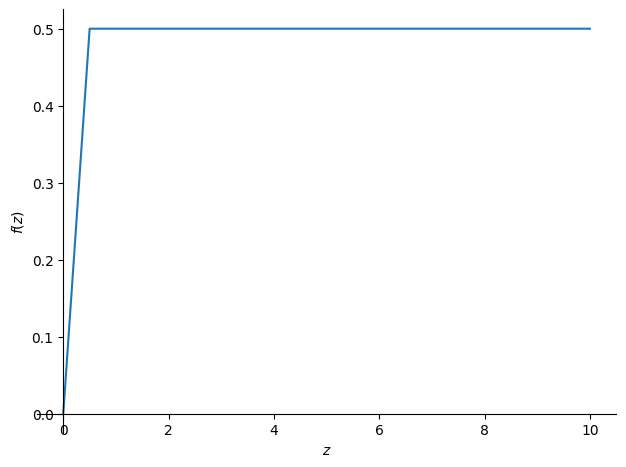

In [8]:
def f1220():
    reset()
    width = Symbol('D')
    dense = Symbol('rho')
    half_width = width / 2
    z = Symbol('z', positive=True)
    S = Symbol('S')
    beautiful_print(S, "choose the size of the surface:$")
    Q = beautiful_compute(Function('Q')(z),
                          Piecewise((2 * z * S * dense, z < half_width), (width * S * dense, z >= half_width)),
                          'distribution of q:$')

    E = Function('E')(z)
    flux = Function('phi')(z)
    flux_cond = beautiful_condition(Eq(flux, 2 * S * E), "easily the flux of E is:$")
    beautiful_solve([flux_cond, Gauss_law], [flux, E], {electric_flux: flux, enclosed_charge_sum: Q})

    beautiful_peek(E, "inlined:$","answer")

    save_as_variable(S, 1)
    save_as_variable(width, 1)
    save_as_variable(epsilon, 1)
    save_as_variable(dense, 1)

    plot(substitute_values(E), (z, 0, 10))


f1220()

### 12.22
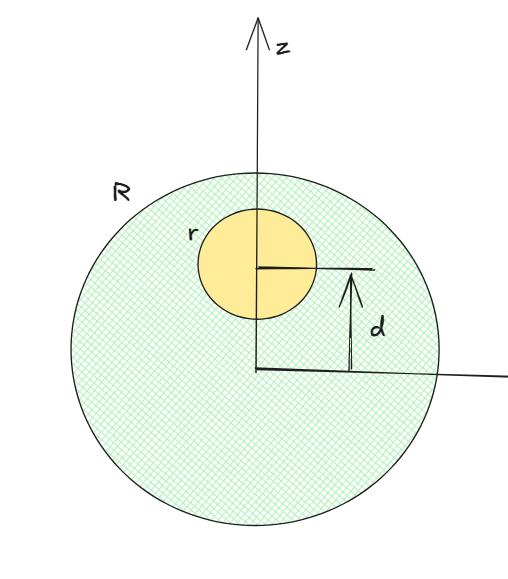

In [9]:
def f1222():
    reset()
    R = Symbol('R', positive=True)
    dense = Symbol('rho', positive=True)
    r = Symbol('r', positive=True)
    d = Symbol('d', positive=True)
    qq = 4 * pi * r ** 3 * dense/3
    qq = beautiful_compute('Q',qq,"sum of Q of a sphere:$")
    qq =substitute_values(qq)
    beautiful_at(E,{q:qq.subs(r,pos.magnitude())},"because:$")
    Ei=beautiful_formula('E_{inside}', E.subs({q: qq.subs(r, pos.magnitude())}))
    ER = beautiful_at(Ei,{r:R,dense:dense},"big sphere makes $E_R$:$")
    Er = beautiful_at(Ei, {z:z-d, r:r,dense:-1* dense},"small sphere (think of it as adding a -$\\rho$ electric sphere to the original sphere makes $E_r$:$")
    beautiful_compute('E_{total}',(ER+Er).simplify(),"so:$","answer")


f1222()

sum of Q of a sphere:$$Q = \frac{4 \pi r^{3} \rho}{3}$$

because:$$E\bigg|_{q=\frac{4 \pi \rho \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}{3}}=\left(\frac{\mathbf{{x}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{k}_{}}$$

$$E_{inside}=\left(\frac{\mathbf{{x}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{k}_{}}\tag{3}$$

big sphere makes $E_R$:$$E_{inside}\bigg|_{r=R\,\rho=\rho}=\left(\frac{\mathbf{{x}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{k}_{}}$$

small sphere (think of it as adding a -$\rho$ electric sphere to the original sphere makes $E_r$:$$E_{inside}\bigg|_{\mathbf{{z}_{}}=\mathbf{{z}_{}} - d\,r=r\,\rho=- \rho}=\left(- \frac{\mathbf{{x}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{i}_{}} + \left(- \frac{\mathbf{{y}_{}} \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\rho \left(- \mathbf{{z}_{}} + d\right)}{3 \epsilon_{0}}\right)\mathbf{\hat{k}_{}}$$

so:$$E_{total} = \left(\frac{d \rho}{3 \epsilon_{0}}\right)\mathbf{\hat{k}_{}}\tag{4}$$

### 12.24

In [13]:

def f1224():
    reset()
    b = Symbol('b', positive=True)
    r = Symbol('r', positive=True)
    ee = Symbol('\\textit{e}', positive=True)
    dense = Function('rho', positive=True)(r)
    E = Function('E')(r)
    flux = Function('phi')(r)
    beautiful_compute(dense,ee/(8*pi*b**3)*exp(-r/b),"given:$")
    Q= integrate(dense*4*pi*r**2,(r,0,r))
    Q = beautiful_compute(Function('Q')(r),Q,"given:$")

    flux_cond = beautiful_condition(Eq(flux, 4* pi * r**2*E), "easily the flux of E for a sphere distribution is:$")
    beautiful_solve([Gauss_law,flux_cond],[E,flux],{electric_flux: flux, enclosed_charge_sum: Q})

    beautiful_peek(E, "inlined:$","answer")
    beautiful_compute(b,0.23E-15,"assign:$")
    beautiful_compute(r,1.0E-15)
    beautiful_compute(epsilon,constants.epsilon_0)
    beautiful_compute(ee,constants.e)
    beautiful_answer(E.evalf(),"and got her:$", f= True)

f1224()

given:$$\rho{\left(r \right)} = \frac{\textit{e} e^{- \frac{r}{b}}}{8 \pi b^{3}}$$

given:$$Q{\left(r \right)} = 4 \pi \int\limits_{0}^{r} r^{2} \rho{\left(r \right)}\, dr$$

easily the flux of E for a sphere distribution is:$$\phi{\left(r \right)} = 4 \pi r^{2} E{\left(r \right)}\tag{3}$$

$\left ( 1 \right ) ,\left ( 3 \right )  \Longrightarrow$

$$E{\left(r \right)} = \frac{Q{\left(r \right)}}{4 \pi \epsilon_{0} r^{2}}$$

$$\phi{\left(r \right)} = \frac{Q{\left(r \right)}}{\epsilon_{0}}$$

inlined:$$E{\left(r \right)} = \frac{\textit{e} \left(2 b^{2} e^{\frac{r}{b}} - 2 b^{2} - 2 b r - r^{2}\right) e^{- \frac{r}{b}}}{8 \pi b^{2} \epsilon_{0} r^{2}}\tag{answer}$$

assign:$$b = 2.3 \cdot 10^{-16}$$

$$r = 1.0 \cdot 10^{-15}$$

$$\epsilon_{0} = 8.8541878188 \cdot 10^{-12}$$

$$\textit{e} = 1.602176634 \cdot 10^{-19}$$

and got her:$$1.1643097573808 \cdot 10^{21}\tag{answer}$$

In [13]:

def f1224():
    reset()
    b = Symbol('b', positive=True)
    r = Symbol('r', positive=True)
    ee = Symbol('\\textit{e}', positive=True)
    dense = Function('rho', positive=True)(r)
    E = Function('E')(r)
    flux = Function('phi')(r)
    beautiful_compute(dense,ee/(8*pi*b**3)*exp(-r/b),"given:$")
    Q= integrate(dense*4*pi*r**2,(r,0,r))
    Q = beautiful_compute(Function('Q')(r),Q,"given:$")

    flux_cond = beautiful_condition(Eq(flux, 4* pi * r**2*E), "easily the flux of E for a sphere distribution is:$")
    beautiful_solve([Gauss_law,flux_cond],[E,flux],{electric_flux: flux, enclosed_charge_sum: Q})

    beautiful_peek(E, "inlined:$","answer")
    beautiful_compute(b,0.23E-15,"assign:$")
    beautiful_compute(r,1.0E-15)
    beautiful_compute(epsilon,constants.epsilon_0)
    beautiful_compute(ee,constants.e)
    beautiful_answer(E.evalf(),"and got her:$", f= True)

f1224()

given:$$\rho{\left(r \right)} = \frac{\textit{e} e^{- \frac{r}{b}}}{8 \pi b^{3}}$$

given:$$Q{\left(r \right)} = 4 \pi \int\limits_{0}^{r} r^{2} \rho{\left(r \right)}\, dr$$

easily the flux of E for a sphere distribution is:$$\phi{\left(r \right)} = 4 \pi r^{2} E{\left(r \right)}\tag{3}$$

$\left ( 1 \right ) ,\left ( 3 \right )  \Longrightarrow$

$$E{\left(r \right)} = \frac{Q{\left(r \right)}}{4 \pi \epsilon_{0} r^{2}}$$

$$\phi{\left(r \right)} = \frac{Q{\left(r \right)}}{\epsilon_{0}}$$

inlined:$$E{\left(r \right)} = \frac{\textit{e} \left(2 b^{2} e^{\frac{r}{b}} - 2 b^{2} - 2 b r - r^{2}\right) e^{- \frac{r}{b}}}{8 \pi b^{2} \epsilon_{0} r^{2}}\tag{answer}$$

assign:$$b = 2.3 \cdot 10^{-16}$$

$$r = 1.0 \cdot 10^{-15}$$

$$\epsilon_{0} = 8.8541878188 \cdot 10^{-12}$$

$$\textit{e} = 1.602176634 \cdot 10^{-19}$$

and got her:$$1.1643097573808 \cdot 10^{21}\tag{answer}$$